이번 시간은 VAE 와 GAN 이죠? 바로 시작해보죠

# 0. Autoencoder


일단 VAE 를 보기 전에 AE 부터 볼겁니다. 설명했듯 Autoencoder 는 들어온 입력값을 복원하도록 학습하는 모델입니다.

이렇게 하는 이유가 있을 거 아니에요? 이는 네트워크가 스스로 알아서 유의미한 feature 를 찾아내도록 학습하기 위해서 입니다. 이렇게 autoencoder 로 한 번 학습하고 난 네트워크는 실제로 classification 문제를 풀도록 학습한 적이 없음에도 불구하고, 유의미한 feature 를 찾아내는 과정을 학습했기 때문에 꽤나 성능이 좋습니다! (이런걸 weight initialization 혹은 network initialization 이라고 합니다.)

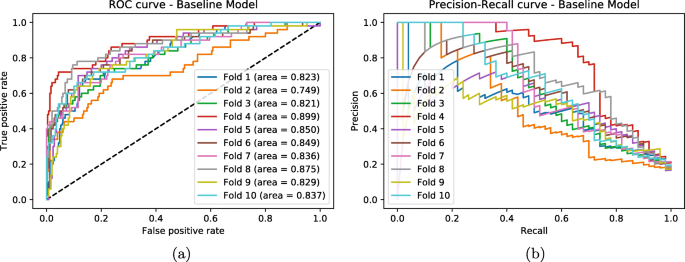



그래프는 ROC curve 라고 하는건데 뭘 의미하는지 잘 몰라도 괜찮습니다. 성능 평가하는 거고 높을수록 좋은데, autoencoder 쓴 빨간색이 다른것보다 높다는 것만 보면 됩니다. 그냥 좋다~

## 0.1. 데이터 불러오기

예제 데이터는 역시 MNIST 를 쓸게요 간단하고 불러오기 편하고.

In [6]:
import torch
import numpy as np
from torchvision import datasets, transforms

batch_size = 32
test_batch_size = 32

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('dataset/',train = True,download = True,
                 transform = transforms.Compose([
                     transforms.ToTensor(),
                     transforms.Normalize(mean = (0.5,), std = (0.5,))
                 ])),
    batch_size = batch_size,
    shuffle = True)


test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('dataset',train=False,
                  transform = transforms.Compose([
                      transforms.ToTensor(),
                     transforms.Normalize(mean = (0.5,), std = (0.5,))
                  ])),
    batch_size = test_batch_size,
    shuffle = True)



In [7]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transfroms

## 0.2. 모델-MLP 버전

In [8]:
import torch
import torch.nn as nn
from torchsummary import summary

class MLP_Autoencoder(nn.Module):
    def __init__(self):
        super(MLP_Autoencoder, self).__init__()
        # Encoder layers
        self.encoder = nn.Sequential(
            nn.Linear(784, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU()
        )

        # Decoder layers
        self.decoder = nn.Sequential(
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 784),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Create the model instance
model = MLP_Autoencoder().to(device)

# Model summary (assuming input size of 784)
summary(model, (784,))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 64]          50,240
              ReLU-2                   [-1, 64]               0
            Linear-3                   [-1, 32]           2,080
              ReLU-4                   [-1, 32]               0
            Linear-5                   [-1, 16]             528
              ReLU-6                   [-1, 16]               0
            Linear-7                   [-1, 32]             544
              ReLU-8                   [-1, 32]               0
            Linear-9                   [-1, 64]           2,112
             ReLU-10                   [-1, 64]               0
           Linear-11                  [-1, 784]          50,960
          Sigmoid-12                  [-1, 784]               0
Total params: 106,464
Trainable params: 106,464
Non-trainable params: 0
-------------------------------

## 0.3. 학습

In [9]:
# Assuming MLP_Autoencoder class and model are already defined as per previous code
# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Number of epochs
epochs = 100

# Training loop
for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    for data, _ in train_loader: # Labels are not used
        # Flatten MNIST images
        data = data.view(data.size(0), -1)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(data)

        # Calculate the loss
        loss = criterion(outputs, data)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * data.size(0)

    # Print average training loss per epoch
    train_loss = train_loss / len(train_loader.dataset)
    print(f"Epoch {epoch+1}, Training Loss: {train_loss:.4f}")

# Testing loop
model.eval()
test_loss = 0.0
with torch.no_grad():
    for data, _ in test_loader:
        data = data.view(data.size(0), -1)
        outputs = model(data)
        loss = criterion(outputs, data)
        test_loss += loss.item() * data.size(0)

test_loss = test_loss / len(test_loader.dataset)
print(f"Test Loss: {test_loss:.4f}")


Epoch 1, Training Loss: 0.9378
Epoch 2, Training Loss: 0.9220
Epoch 3, Training Loss: 0.9101
Epoch 4, Training Loss: 0.8941
Epoch 5, Training Loss: 0.8842
Epoch 6, Training Loss: 0.8807
Epoch 7, Training Loss: 0.8790
Epoch 8, Training Loss: 0.8777
Epoch 9, Training Loss: 0.8763
Epoch 10, Training Loss: 0.8752
Test Loss: 0.8725


## 0.4. 결과 시각화

In [13]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

# Assuming model is already trained

# Get a batch of data from the train loader
images, _ = next(iter(train_loader))

# Display 10 images
for i in range(10):
    # Original image
    original = images[i].numpy().squeeze()  # Squeeze to remove channel dimension
    original = (original - np.min(original)) / np.max(original - np.min(original)) * 255
    print("ORIGINAL:")
    cv2_imshow(original.astype(np.uint8))

    # Reconstructed image
    with torch.no_grad():
        model.eval()
        input_image = images[i].view(-1, 784)
        reconstructed = model(input_image).numpy().squeeze()
        reconstructed = (reconstructed - np.min(reconstructed)) / np.max(reconstructed - np.min(reconstructed)) * 255
    print("GENERATED:")
    reconstructed = reconstructed.reshape((28,28))

    cv2_imshow(reconstructed.astype(np.uint8))

    print('*'*50)


ORIGINAL:


GENERATED:


**************************************************
ORIGINAL:


GENERATED:


**************************************************
ORIGINAL:


GENERATED:


**************************************************
ORIGINAL:


GENERATED:


**************************************************
ORIGINAL:


GENERATED:


**************************************************
ORIGINAL:


GENERATED:


**************************************************
ORIGINAL:


GENERATED:


**************************************************
ORIGINAL:


GENERATED:


**************************************************
ORIGINAL:


GENERATED:


**************************************************
ORIGINAL:


GENERATED:


**************************************************


나름 나쁘지 않죠?

## 0.5. 다른 모델?

여러분들이 CNN 을 쓰고 싶을 수 있을거에요. 왜냐하면 여러분이 다루는 이미지 데이터는 28 * 28 의 간단한 이미지가 아닐테니까요.

그럴땐 `tf.keras.layers.Conv2DTranspose`를 이용하면됩니다!

이건 모델을 직접 학습시키진 않을게요 궁금하면 해보십쇼

In [17]:
class CNN_Autoencoder(nn.Module):
    def __init__(self):
        super(CNN_Autoencoder, self).__init__()

        # Encoder layers
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1),  # Output: 16 x 14 x 14
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1), # Output: 32 x 7 x 7
            nn.ReLU(),
            nn.Conv2d(32, 64, 7)                      # Output: 64 x 1 x 1
        )

        # Decoder layers
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 7),            # Output: 32 x 7 x 7
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1), # Output: 16 x 14 x 14
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),  # Output: 1 x 28 x 28
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Create the CNN autoencoder model
model = CNN_Autoencoder()

summary(model, (1,28,28))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 14, 14]             160
              ReLU-2           [-1, 16, 14, 14]               0
            Conv2d-3             [-1, 32, 7, 7]           4,640
              ReLU-4             [-1, 32, 7, 7]               0
            Conv2d-5             [-1, 64, 1, 1]         100,416
   ConvTranspose2d-6             [-1, 32, 7, 7]         100,384
              ReLU-7             [-1, 32, 7, 7]               0
   ConvTranspose2d-8           [-1, 16, 14, 14]           4,624
              ReLU-9           [-1, 16, 14, 14]               0
  ConvTranspose2d-10            [-1, 1, 28, 28]             145
          Sigmoid-11            [-1, 1, 28, 28]               0
Total params: 210,369
Trainable params: 210,369
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/

# 1. VAE

자 그럼 이제 VAE 를 볼건데요, 이거 위의 내용에서 한 가지 부분만 바뀌는거라 너무 쉽습니다. 우리가 gaussian 분포의 feature vector 로 강제 시키고 거기서 sampling 한다고 했죠?

이걸 대충 그렇게 되기를 바라면서 학습시켰던 MLP 와는 다르게, 직접적으로 gaussian 분포로 뽑을거에요. 즉 encoder network 의 아웃픗으로 나오는게 어떤 벡터라기보다는 정확히 말하면 gaussian 분포의 파라미터들 (평균과 표준편차: $\mu$ 와 $\sigma$) 이라는 겁니다

$$\mathcal{N}(\mu, \sigma)$$



## 1.1. 데이터 불러오기

예제 데이터는 역시 다시 믿음과 신뢰의 MNIST

In [18]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Loading CIFAR-10 data
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


100%|██████████| 170498071/170498071 [00:02<00:00, 72221265.28it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


## 1.2. 모델

In [30]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, 3, stride=2, padding=1),  # Output: 16 x 16 x 16
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1), # Output: 32 x 8 x 8
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(32 * 8 * 8, 400),
            nn.ReLU()
        )
        self.fc_mu = nn.Linear(400, 100)
        self.fc_logvar = nn.Linear(400, 100)

        # Decoder
        self.decoder_fc = nn.Linear(100, 32 * 8 * 8)
        self.decoder = nn.Sequential(
            nn.Unflatten(1, (32, 8, 8)),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1), # Output: 16 x 16 x 16
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, 3, stride=2, padding=1, output_padding=1),  # Output: 3 x 32 x 32
            nn.Sigmoid()
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        h = self.encoder(x)
        mu, logvar = self.fc_mu(h), self.fc_logvar(h)
        z = self.reparameterize(mu, logvar)
        return self.decoder(self.decoder_fc(z)), mu, logvar

model = VAE().to(device)

summary(model, (3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 16, 16]             448
              ReLU-2           [-1, 16, 16, 16]               0
            Conv2d-3             [-1, 32, 8, 8]           4,640
              ReLU-4             [-1, 32, 8, 8]               0
           Flatten-5                 [-1, 2048]               0
            Linear-6                  [-1, 400]         819,600
              ReLU-7                  [-1, 400]               0
            Linear-8                  [-1, 100]          40,100
            Linear-9                  [-1, 100]          40,100
           Linear-10                 [-1, 2048]         206,848
        Unflatten-11             [-1, 32, 8, 8]               0
  ConvTranspose2d-12           [-1, 16, 16, 16]           4,624
             ReLU-13           [-1, 16, 16, 16]               0
  ConvTranspose2d-14            [-1, 3,

## 1.3. 학습

In [31]:
# Loss function
def loss_function(recon_x, x, mu, logvar):
    BCE = nn.functional.mse_loss(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

# Assume the same loss_function as before
optimizer = optim.Adam(model.parameters(), lr=1e-3)

for epoch in range(10):  # Example for 10 epochs
    model.train()
    train_loss = 0
    for data, _ in train_loader:
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data.to(device))
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    print(f"Epoch {epoch + 1}, Average Loss: {train_loss / len(train_loader.dataset):.4f}")


Epoch 1, Average Loss: 640.1740
Epoch 2, Average Loss: 570.1852
Epoch 3, Average Loss: 554.2859
Epoch 4, Average Loss: 548.1652
Epoch 5, Average Loss: 545.5950
Epoch 6, Average Loss: 543.6145
Epoch 7, Average Loss: 542.4130
Epoch 8, Average Loss: 541.4032
Epoch 9, Average Loss: 540.6775
Epoch 10, Average Loss: 540.0653


## 1.4. 결과 시각화

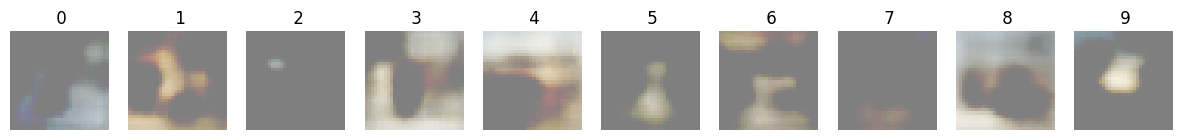

In [32]:
def show_images(images, title=""):
    fig, axs = plt.subplots(1, len(images), figsize=(15, 15))
    for i, img in enumerate(images):
        img = img.detach().numpy().transpose(1, 2, 0)
        img = img * 0.5 + 0.5  # Unnormalize
        axs[i].imshow(img.clip(0, 1))
        axs[i].set_title(title + " " + str(i))
        axs[i].axis('off')
    plt.show()

# Sample z from the normal distribution
num_samples = 10
z = torch.randn(num_samples, 100)  # 100 is the latent vector size

# Generate images
with torch.no_grad():
    model.eval()
    generated_images = model.decoder(model.decoder_fc(z))

# Visualize
show_images(generated_images)


# 2. GAN

드디어..!

근데 AE 나 VAE 랑 조금 많이 다르기 때문에 좀 잘 따라와보십쇼

수업할때도 (아마도) 들었겠지만 이건 결국 loss function 어떻게 잘 정의하고 그걸 번갈아가면서 - 각각 discriminator 와 generator를 각각 학습을 잘 시키는 부분이 매우매우 중요합니다.

그 부분을 찾아서 이해하면 정말 최고에요.



## 2.1. 데이터 불러오기

In [33]:
import torch
import numpy as np
from torchvision import datasets, transforms

batch_size = 32
test_batch_size = 32

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('dataset/',train = True,download = True,
                 transform = transforms.Compose([
                     transforms.ToTensor(),
                     transforms.Normalize(mean = (0.5,), std = (0.5,))
                 ])),
    batch_size = batch_size,
    shuffle = True)


test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('dataset',train=False,
                  transform = transforms.Compose([
                      transforms.ToTensor(),
                     transforms.Normalize(mean = (0.5,), std = (0.5,))
                  ])),
    batch_size = test_batch_size,
    shuffle = True)



## 2.2. 모델

이것도 vae 처럼 구조화 해야 사용하기 편합니다.

In [34]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(100, 128),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(128, 0.8),
            nn.Linear(128, 256),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(256, 0.8),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(512, 0.8),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(1024, 0.8),
            nn.Linear(1024, 28*28),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.size(0), 1, 28, 28)
        return img


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        validity = self.model(img_flat)
        return validity


generator = Generator().to(device)
discriminator = Discriminator().to(device)

## 2.3. 학습

아 이게 어려운데 잘 해봅시다.

어려운 부분은 저 두 녀석의 두 optimizer 를 각각 피팅을 해야한다는거에요. 그럴려면 단순하게 우리 여태 했던대로 `loss.backward()` 랑 `optimizer.step` 모델이 두개니까...

그걸 잘 봅시다.

In [35]:
generator = Generator()
discriminator = Discriminator()

optimizer_G = torch.optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

adversarial_loss = torch.nn.BCELoss()


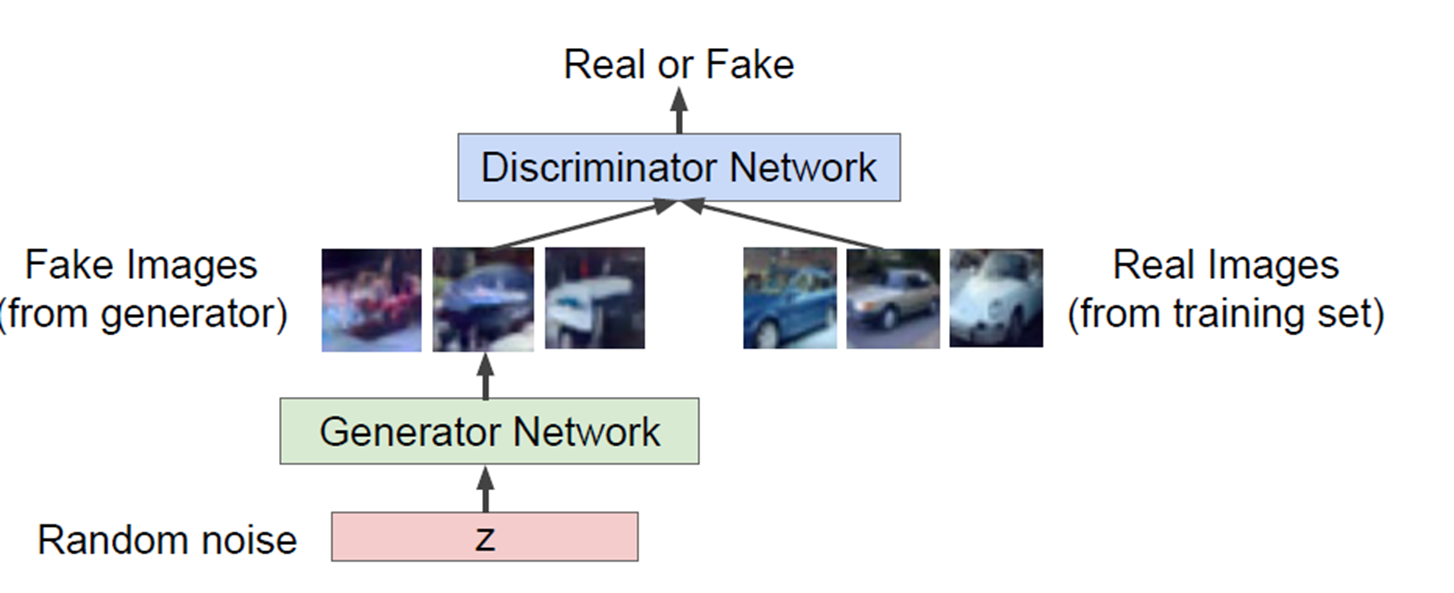

먼저 위 그림에서 정보의 흐름을 기억하면 좀 편한데요,

noise --> generator --> discriminator 죠?

In [36]:
n_epochs = 50  # Number of epochs

for epoch in range(n_epochs):
    for i, (imgs, _) in enumerate(train_loader):

        # Ground truths
        valid = torch.ones(imgs.size(0), 1, device=imgs.device)
        fake = torch.zeros(imgs.size(0), 1, device=imgs.device)

        # Configure input
        real_imgs = imgs.to(device)

        # -----------------
        #  Train Generator
        # -----------------

        optimizer_G.zero_grad()

        # Sample noise as generator input
        z = torch.randn(imgs.shape[0], 100, device=imgs.device)

        # Generate a batch of images
        gen_imgs = generator(z)

        # Loss measures generator's ability to fool the discriminator
        g_loss = adversarial_loss(discriminator(gen_imgs), valid)

        g_loss.backward()
        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        # Measure discriminator's ability to classify real from generated samples
        real_loss = adversarial_loss(discriminator(real_imgs), valid)
        fake_loss = adversarial_loss(discriminator(gen_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()

    print(f"[Epoch {epoch}/{n_epochs}] [D loss: {d_loss.item()}] [G loss: {g_loss.item()}]")


[Epoch 0/50] [D loss: 0.4222407341003418] [G loss: 1.4770734310150146]
[Epoch 1/50] [D loss: 0.40896499156951904] [G loss: 2.6923513412475586]
[Epoch 2/50] [D loss: 0.41905108094215393] [G loss: 0.8389521837234497]
[Epoch 3/50] [D loss: 0.2842785120010376] [G loss: 1.637404441833496]
[Epoch 4/50] [D loss: 0.2610297203063965] [G loss: 2.4486629962921143]
[Epoch 5/50] [D loss: 0.21913094818592072] [G loss: 2.28564715385437]
[Epoch 6/50] [D loss: 0.27466005086898804] [G loss: 1.5544545650482178]
[Epoch 7/50] [D loss: 0.14976565539836884] [G loss: 2.027574300765991]
[Epoch 8/50] [D loss: 0.6657849550247192] [G loss: 4.718471527099609]
[Epoch 9/50] [D loss: 0.3384284973144531] [G loss: 3.1711063385009766]
[Epoch 10/50] [D loss: 0.22570902109146118] [G loss: 1.7334184646606445]
[Epoch 11/50] [D loss: 0.34863829612731934] [G loss: 1.2636994123458862]
[Epoch 12/50] [D loss: 0.4617675542831421] [G loss: 1.1143267154693604]
[Epoch 13/50] [D loss: 0.2313096672296524] [G loss: 1.8374974727630615]


## 2.4. 결과 시각화

In [39]:
import matplotlib.pyplot as plt

def show_generated_images(generator, num_images=10):
    # Sample noise
    z = torch.randn(num_images, 100, device=next(generator.parameters()).device)

    # Generate images
    with torch.no_grad():
        generator.eval()
        generated_images = generator(z)

    # Display images
    fig, axes = plt.subplots(1, num_images, figsize=(20, 2))
    for i, img in enumerate(generated_images):
        img = img.cpu().view(28, 28).numpy()  # Reshape and move to CPU for visualization
        axes[i].imshow(img, cmap='gray')
        axes[i].axis('off')
    plt.show()


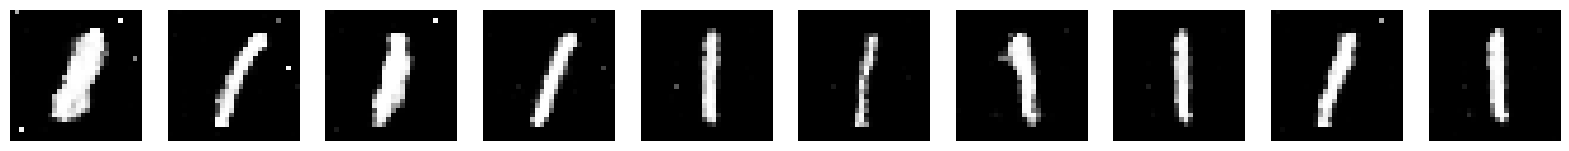

In [40]:
show_generated_images(generator)

In [43]:

def show_generated_images(generator, num_images=10):
    # Sample noise
    z = torch.randn(num_images, 100, device=next(generator.parameters()).device)

    z[:,0] += 2

    # Generate images
    with torch.no_grad():
        generator.eval()
        generated_images = generator(z)

    # Display images
    fig, axes = plt.subplots(1, num_images, figsize=(20, 2))
    for i, img in enumerate(generated_images):
        img = img.cpu().view(28, 28).numpy()  # Reshape and move to CPU for visualization
        axes[i].imshow(img, cmap='gray')
        axes[i].axis('off')
    plt.show()


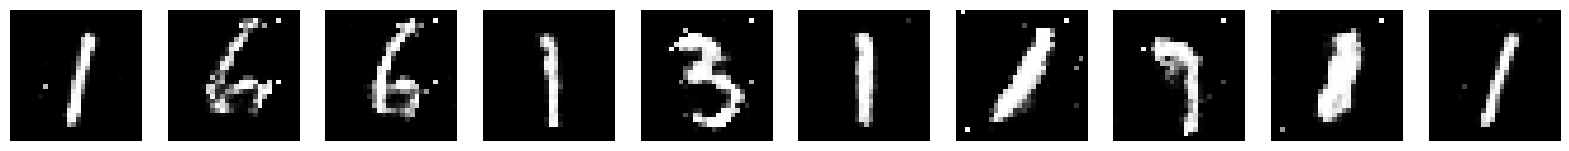

In [44]:
show_generated_images(generator)

왜 잘 안나왔을까요?

1. 당연히 training 이 부족한것도 있죠

2. 그러나 칼라 이미지기 때문에, CNN 을 쓰는 GAN 모델이 더 유의미할 수 있겠습니다.

3. CNN 을 쓰는 GAN (Deep convolution GAN, DCGAN) 을 쓰더라도 학습에 시간이 많이 걸리기 때문에.. 오래오래 해야겠죠?

  - 어떻게 만드나요?

    당연하게도, Conv2DTranspose를 써서 만드시면됩니다.

